# 9 GLMのベイズモデル化と事後分布の推定

In [1]:
using CSV
using DataFrames
using GLM
using LaTeXStrings
using Mamba
using Plots

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [2]:
df = CSV.read("data/section9.csv");
disallowmissing!(df)

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


In [3]:
df

,x,y
,Float64,Int64
1,3.0,5
2,3.21053,3
3,3.42105,6
4,3.63158,7
5,3.84211,7
6,4.05263,5
7,4.26316,9
8,4.47368,9
9,4.68421,7


## 9.1 例題 : 種子数のポアソン回帰 (個体差なし)

In [4]:
glm_model = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.56606  0.359949 4.35077    <1e-4
x            0.0833412 0.0683847 1.21871   0.2230


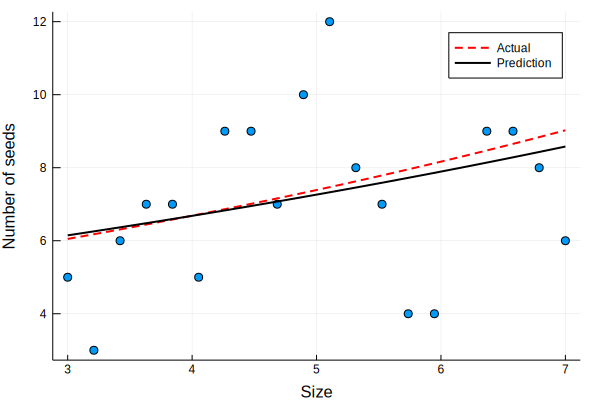

In [5]:
scatter(df.x, df.y, label = "", xlabel = "Size", ylabel = "Number of seeds")
xs = 3:0.1:7
xx = DataFrame(x = xs)
plot!(xs, exp.(1.5 .+ 0.1 .* xs), label = "Actual", linewidth = 2, 
    linestyle = :dash, linecolor = :red)
plot!(xs, predict(glm_model, xx), label = "Prediction", linewidth = 2, 
    linecolor = :black)

## 9.4 ベイズ統計モデルの事後分布の推定
### 9.4.1 ベイズ統計モデルのコーディング
\begin{align}
                y_i & \sim \text{Poisson}(\lambda_i)\\
    \log(\lambda_i) & =    \beta_1 + \beta_2 \cdot x_i\\
            \beta_1 & \sim \text{Normal}(0, 100^2)\\
            \beta_2 & \sim \text{Normal}(0, 100^2)
\end{align}
Mamba.jl ( https://mambajl.readthedocs.io/ )を使う
### モデルの作成

In [6]:
model = Model(
    y = Stochastic(1,
        (beta1, beta2, x, N) ->
        UnivariateDistribution[
            (lambda = exp(beta1 + beta2 * x[i]);
            Poisson(lambda)) for i in 1:N
        ],
        false),
    beta1 = Stochastic(
        () -> Normal(0.0, 100^2)),
    beta2 = Stochastic(
        () -> Normal(0.0, 100^2)),
    )

Object of type "Model"
-------------------------------------------------------------------------------
beta2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStochastic"
NaN


### データの設定

In [7]:
data = Dict{Symbol, Any}(
  :x => df.x,
  :y => df.y
)
data[:N] = length(data[:x])
data

Dict{Symbol,Any} with 3 entries:
  :N => 20
  :y => [5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6]
  :x => [3.0, 3.21053, 3.42105, 3.63158, 3.84211, 4.05263, 4.26316, 4.47368, 4.…

### 初期値の設定

In [8]:
inits = [
    Dict{Symbol, Any}(
    :y => df.y,
    :beta1 => 0,
    :beta2 => 0
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta2=>0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0)
 Dict(:beta2=>0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0)
 Dict(:beta2=>0,:y=>[5, 3, 6, 7, 7, 5, 9, 9, 7, 10, 12, 8, 7, 4, 4, 11, 9, 9, 8, 6],:beta1=>0)

### サンプラーの設定

In [9]:
scheme = [NUTS([:beta1, :beta2])]

1-element Array{Sampler{Mamba.NUTSTune},1}:
 An object of type "Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
Symbol[:beta1, :beta2]

CodeInfo(
1 ─ %1 = π (##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), Const(##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


### MCMC シミュレーション

In [10]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 1600, burnin = 100, thin = 3, chains = 3)

MCMC Simulation of 1600 Iterations x 3 Chains...

Chain 1:   1% [0:02:39 of 0:02:40 remaining]
Chain 1:  10% [0:00:13 of 0:00:15 remaining]
Chain 1:  20% [0:00:07 of 0:00:08 remaining]
Chain 1:  30% [0:00:04 of 0:00:06 remaining]
Chain 1:  40% [0:00:03 of 0:00:05 remaining]
Chain 1:  50% [0:00:02 of 0:00:05 remaining]
Chain 1:  60% [0:00:02 of 0:00:04 remaining]
Chain 1:  70% [0:00:01 of 0:00:04 remaining]
Chain 1:  80% [0:00:01 of 0:00:04 remaining]
Chain 1:  90% [0:00:00 of 0:00:03 remaining]
Chain 1: 100% [0:00:00 of 0:00:03 remaining]

Chain 2:   1% [0:00:01 of 0:00:01 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:02 of 0:00:02 remaining]
Chain 2:  30% [0:00:01 of 0:00:02 remaining]
Chain 2:  40% [0:00:01 of 0:00:02 remaining]
Chain 2:  50% [0:00:01 of 0:00:02 remaining]
Chain 2:  60% [0:00:01 of 0:00:02 remaining]
Chain 2:  70% [0:00:01 of 0:00:02 remaining]
Chain 2:  80% [0:00:00 of 0:00:02 remaining]
Chain 2:  90% [0:00:00 of 0:00:02 remaining]
Chai

Object of type "ModelChains"

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

[1.65623 0.0740847; 1.56701 0.093073; … ; 1.83175 0.0379474; 1.67731 0.0601865]

[1.93684 -0.00842389; 1.88348 -0.00724271; … ; 1.14359 0.195243; 1.65402 0.0360463]

[1.9802 -0.00775644; 2.03598 -0.0177721; … ; 0.91576 0.179436; 1.52811 0.0947942]

### シミュレーション結果の表示と図示

In [11]:
describe(sim)

Iterations = 103:1600
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 500

Empirical Posterior Estimates:
         Mean       SD       Naive SE       MCSE     ESS
beta1 1.5712585 0.37987092 0.0098082251 0.0130649114 500
beta2 0.0805701 0.07178907 0.0018535857 0.0024325733 500

Quantiles:
         2.5%       25.0%       50.0%      75.0%      97.5%  
beta1  0.8496701 1.326492214 1.57683428 1.82602247 2.32164441
beta2 -0.0643676 0.032938896 0.07934183 0.12653825 0.22398369



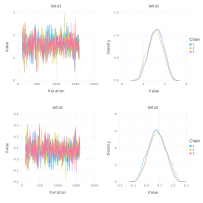

In [12]:
p = Mamba.plot(sim, legend = true)
draw(p, nrow = 2, ncol = 2)

### Estimate Potential Scale Reduction Factor
Gelman-Rubin diagnostic ($\hat{R}$)

In [13]:
gelmandiag(sim, mpsrf = true, transform = true)

              PSRF 97.5%
       beta1 1.003 1.009
       beta2 1.002 1.009
Multivariate 1.003   NaN

